# Introduction

This notebook gives a quick overview of emulator internal routines, for both ring-oscillators (RO) emulation and raw random number (RRN) emulation. This example emulates ROs and RRN in a 28nm FD-SOI electronic component.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import emulator

# Technology settings

Setup and hold times for generic 28nm FD-SOI

In [2]:
ts = 19.90e-12
th = 10.37e-12

# Emulate noisy ring-oscillators

Generate 100,000 periods for two ring-oscillators at 498MHz and 501MHz

In [3]:
ro0 = emulator.generate_periods(emulator.GENPERIODS, 498e6, emulator.A1_F500M, emulator.A2_F500M)
ro1 = emulator.generate_periods(emulator.GENPERIODS, 501e6, emulator.A1_F500M, emulator.A2_F500M)

Plot instantaneous periods for both rings and display mean period as well as its standard deviation

(2.0079663270790983e-09, 5.189426135758633e-12)

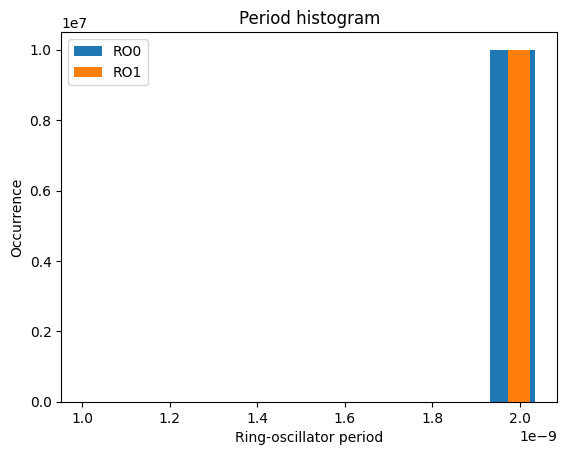

In [4]:
plt.hist(ro0, label='RO0')
plt.hist(ro1, label='RO1')
plt.legend()
plt.title("Period histogram")
plt.xlabel("Ring-oscillator period")
plt.ylabel("Occurrence")
np.mean(ro0), np.std(ro0)

# Emulate raw random numbers

## Elementary Ring-Oscillator (ERO)

Generate the random bits

In [5]:
bits, valid, resolved = emulator.ero(1000, ro0, ro1, ts, th)

Plot the first 100 generated raw random bits and display their bias

0.4913975249019016

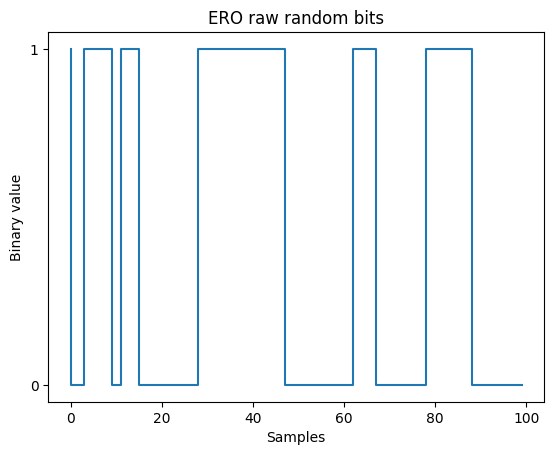

In [6]:
limit = 100
plt.step(range(limit), bits[:limit])
plt.title("ERO raw random bits")
plt.xlabel("Samples")
plt.ylabel("Binary value")
plt.yticks([0, 1])
np.mean(bits)

## Multi Ring-Oscillators (MURO)

For the MURO (t=5) we replace RO1 with multiple ring-oscillators, here 5 ROs

In [7]:
fx = [488e6, 497e6, 501e6, 503e6, 509e6]
t = len(fx)

In [8]:
rox = np.empty((0, emulator.GENPERIODS))
for f in fx[1:]:
    ro = emulator.generate_periods(emulator.GENPERIODS, f, emulator.A1_F500M, emulator.A2_F500M)
    rox = np.vstack((rox, ro))

Generate the random bits

In [9]:
bits, valid, resolved = emulator.muro(1000, rox[0], rox[1:], ts, th)

Plot the first 100 generated raw random bits and display their bias

0.5007682064939055

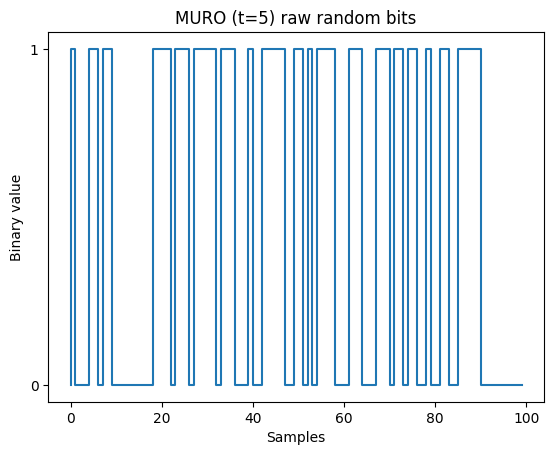

In [10]:
limit = 100
plt.step(range(limit), bits[:limit])
plt.title("MURO (t={:d}) raw random bits".format(t))
plt.xlabel("Samples")
plt.ylabel("Binary value")
plt.yticks([0, 1])
np.mean(bits)

## Coherent Sampling Ring-Oscillator (COSO)

Generate raw random values

In [11]:
counter = emulator.coso(ro0, ro1)

Plot the distributions of generated counter values and measure their mean value

164.20951169552004

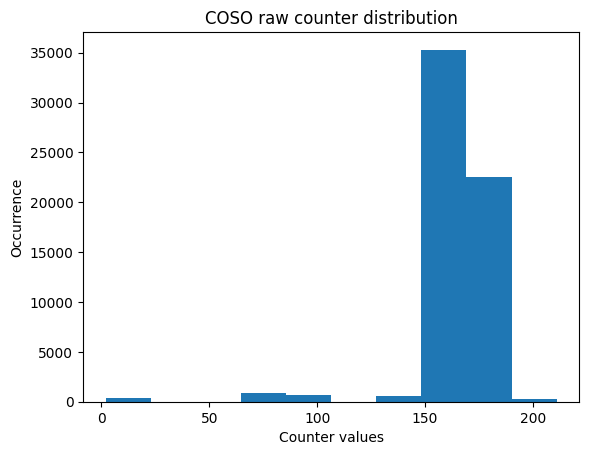

In [12]:
plt.hist(counter)
plt.title("COSO raw counter distribution")
plt.xlabel("Counter values")
plt.ylabel("Occurrence")
np.mean(counter)

Extract the raw random bits by selecting the less significant bit (LSB)

In [13]:
bits = counter%2

Plot the first 100 generated raw random bits and display their bias

0.4952920576186071

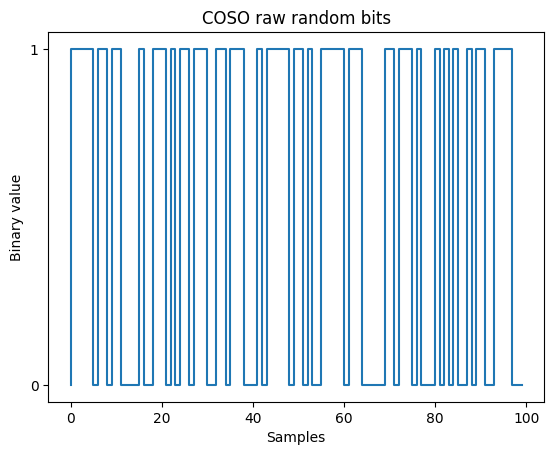

In [14]:
limit = 100
plt.step(range(limit), bits[:limit])
plt.title("COSO raw random bits")
plt.xlabel("Samples")
plt.ylabel("Binary value")
plt.yticks([0, 1])
np.mean(bits)